# Functions

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from numpy import linalg as LA
from sklearn.mixture import GaussianMixture
import seaborn as sns


In [2]:
def plot(x_1_labeled, x_2_labeled, x_unlabeled, W_OPT= np.ones(2)/np.sqrt(2), GAMMA=None , LIM=10):
  _, ax = plt.subplots(figsize=(10,10))
  ax.set_aspect('equal', adjustable='box')
  ax.set_xlim(-LIM, LIM)
  ax.set_ylim(-LIM, LIM)


#   # opt & margin
#   _x = np.linspace(-LIM, LIM, 100)
#   _y = - W_OPT[0] * _x / W_OPT[1]
#   ax.plot(_x, _y, c='black')

  if GAMMA is not None:   
    ax.plot(_x, _y + GAMMA, c='grey')
    ax.plot(_x, _y - GAMMA, c='grey')


    ax.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], marker='.', c='lightblue', s=5, label='unl')
    ax.scatter(x_1_labeled[:, 0],x_1_labeled[:, 1], marker='+', c='blue', s=20, label='0')
    ax.scatter(x_2_labeled[:, 0], x_2_labeled[:, 1], marker='_', c='red', s=20, label='1')
    plt.legend()
    return plt

In [3]:
def expectation_maximization_kmeans_init(x_unlabeled):
#     print(x_unlabeled[0], x_unlabeled.shape)
    gm = GaussianMixture(n_components=2, random_state=0, covariance_type='spherical').fit(x_unlabeled)
    return gm.means_

In [4]:
def expectation_maximization_supervised_init(x_unlabeled,x_1_labeled, x_2_labeled ):
    mean_1 = np.mean(x_1_labeled, axis=0)
    mean_2 = np.mean(x_2_labeled, axis=0)
    means_init = np.append(mean_1[None, :], mean_2[None, :] ,axis=0)
    gm = GaussianMixture(n_components=2, random_state=0, means_init = means_init).fit(x_unlabeled)
    return gm.means_

In [5]:
from sklearn.linear_model import LogisticRegression
def get_sup_estimator(x_labelled, y):
    clf = LogisticRegression(random_state=0).fit(x_labelled, y)
    return clf


In [65]:
from sklearn.linear_model import LogisticRegression
def get_unsup_estimator(x_unlabelled, x_val, y_val):
    em_means = expectation_maximization_kmeans_init(x_unlabelled)
    clf_em = LogisticRegression(random_state=0)
    clf_em.coef_=(em_means[0] - em_means[1]).reshape(1,-1)
    clf_em.intercept_=0
    clf_em.classes_=np.unique(y_val)
    if clf_em.score(x_val, y_val) <0.5:
        clf_em.coef_*=-1
    return clf_em

In [7]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
import openml
data = openml.datasets.get_dataset('mnist_784')
x, y, _, _ = data.get_data(target=data.default_target_attribute)
x = x.to_numpy()
y = y.to_numpy(dtype="int")
scaler = preprocessing.StandardScaler()


In [50]:
class1=5
class2=9
x_subset=np.concatenate((x[y==class1],x[y==class2]) )
x_scaled=scaler.fit_transform(x_subset)
y_subset=np.concatenate((y[y==class1], y[y==class2]))
# pca=PCA(n_components=2)
pca=PCA(n_components=20)
x_trans=pca.fit_transform(x_scaled)
perm_idx=np.random.permutation(len(x_trans))
x_trans=x_trans[perm_idx]
y_subset=y_subset[perm_idx]



In [9]:

# plt=plot(x_labelled[y==class1], 
#      x_labelled[y==class2], 
#      x_unlabelled, LIM=30)
# plt.scatter(x=np.mean(em_means[:,0]),y=np.mean(em_means[:,1]), s=52,c='g', )
# plt.scatter(x=clf.coef_[:,0],y=clf.coef_[:,1], marker='x', s=52,c='b', )


In [10]:

def get_ssl_estimator(clf_sl, clf_em, lambda_):
    clf_ssl = LogisticRegression(random_state=0)
    w=lambda_*clf_em.coef_ + (1-lambda_)*clf_sl.coef_
    w0=(1-lambda_)*clf_sl.intercept_

    clf_ssl.coef_=w
    clf_ssl.intercept_=w0
    clf_ssl.classes_=clf_sl.classes_
    return clf_ssl


Text(0, 0.5, 'Accuracy')

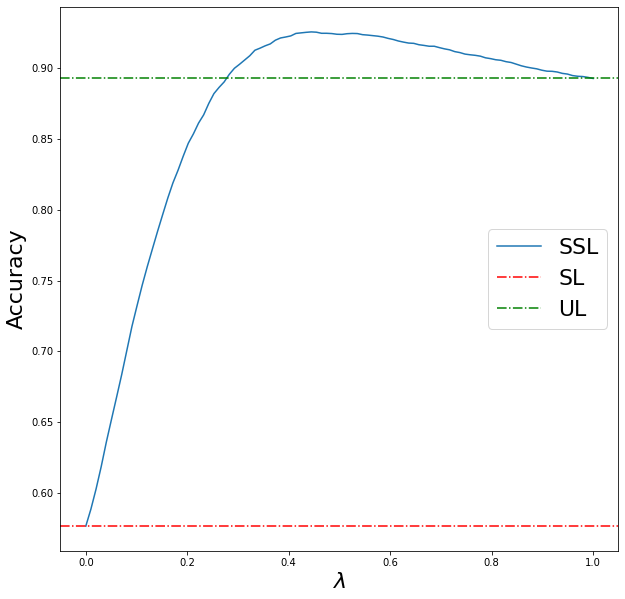

In [11]:
n_labelled=6
n_unlabelled=3000
x_labelled=x_trans[0:n_labelled]
x_unlabelled=x_trans[n_labelled:n_labelled+n_unlabelled]
y_sl=y_subset[0:n_labelled]

x_test=x_trans[n_labelled+n_unlabelled:]
y_test=y_subset[n_labelled+n_unlabelled:]



plt.figure(figsize=(10,10))
clf_sl=get_sup_estimator(x_labelled, y_sl)
clf_em=get_unsup_estimator(x_unlabelled, x_test, y_test)

sl_score=clf_sl.score(x_test, y_test)
ul_score=clf_em.score(x_test, y_test)

score_arr=[]
for lambda_ in np.linspace(0,1,100):
    clf_ssl=get_ssl_estimator(clf_sl, clf_em, lambda_)
    score_arr.append(clf_ssl.score(x_test, y_test))

plt.plot(np.linspace(0,1,100), score_arr, label='SSL')
plt.axhline(sl_score, label='SL', color='r', linestyle='-.',)
plt.axhline(ul_score, label='UL', linestyle='-.', color='g')
plt.legend(fontsize=22)
plt.xlabel('$\lambda$', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)

In [17]:
from tqdm import tqdm
def get_best_lambda(clf_sl, clf_em, x_val, y_val):    
    score_arr=[]
    best_lambda=0
    best_score=0
    for lambda_ in np.linspace(0,1,1000):
        clf_ssl=get_ssl_estimator(clf_sl, clf_em, lambda_)
        score_curr = clf_ssl.score(x_val, y_val)
        if score_curr > best_score:
            best_lambda=lambda_
            best_score = score_curr
    return best_lambda, best_score

In [13]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
from sklearn.datasets import fetch_openml


def get_classes(x,y, class1=2, class2=3):
    scaler = preprocessing.StandardScaler()
    # class1=2
    # class2=3
    pca=PCA(n_components=2)
    x_subset=np.concatenate((x[y==class1],x[y==class2]) )
    x_scaled=scaler.fit_transform(x_subset)
    x_trans=pca.fit_transform(x_scaled)
    y_subset=np.concatenate((y[y==class1], y[y==class2]))
    perm_idx=np.random.permutation(len(x_trans))
    x_trans=x_trans[perm_idx]
    y_subset=y_subset[perm_idx]
    return x_trans, y_subset




In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
def get_self_training_estimator(x_labelled, y, x_unlabelled):
    all_xs = np.concatenate((x_labelled, x_unlabelled))
    all_ys = np.concatenate((y, -np.ones(x_unlabelled.shape[0])))
    clf = LogisticRegression(random_state=0)
    self_training_model = SelfTrainingClassifier(clf).fit(all_xs, all_ys)
    return self_training_model


In [78]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import PredefinedSplit, GridSearchCV
def get_labelprop_estimator(x_labelled, y, x_unlabelled, x_val, y_val):
    all_xs = np.concatenate((x_labelled, x_unlabelled, x_val))
    all_ys = np.concatenate((y, -np.ones(x_unlabelled.shape[0]), y_val))
    val_idxs = np.concatenate((-np.ones(x_labelled.shape[0]+x_unlabelled.shape[0]), np.zeros(x_val.shape[0])))
    ps = PredefinedSplit(test_fold=val_idxs)
    print(ps.get_n_splits())
    clf = LabelPropagation(kernel="knn", n_jobs=8, max_iter=10000)
    grid_search = GridSearchCV(clf, param_grid={"n_neighbors": [3, 4, 6]}, cv=ps).fit(all_xs, all_ys)
    return grid_search


In [81]:

from tqdm import tqdm
import statistics

# fig,ax=plt.subplots(2,1,figsize=(10,10))
n_labelled_arr=np.arange(2,20)
n_unlabelled_arr=[4000]


x_test=x_trans[n_labelled_arr[-1]+n_unlabelled_arr[-1]:]
y_test=y_subset[n_labelled_arr[-1]+n_unlabelled_arr[-1]:]

ssl_arr=[]
theory_arr=[]
lambda_arr=[]

sl_arr=[]
st_arr=[]
lp_arr=[]
ul_arr=[]
sl_diff_arr=[]
ul_diff_arr=[]
st_diff_arr=[]
lp_diff_arr=[]

n_labelled_arrs=[]
n_unlabelled_arrs=[]


x_train=x_trans[:-2000]
y_train=y_subset[:-2000]
x_val=x_trans[-2000:-1000]
y_val=y_subset[-2000:-1000]
x_test=x_trans[-1000:]
y_test=y_subset[-1000:]


for trial_idx in tqdm(range(30)):
    perm_idx=np.random.permutation(len(x_train))
    x_train=x_train[perm_idx]
    y_train=y_train[perm_idx]

    for n_labelled in n_labelled_arr:
        for n_unlabelled in n_unlabelled_arr:
            x_labelled=x_train[0:n_labelled]
            x_unlabelled=x_train[n_labelled:n_labelled+n_unlabelled]
            y_sl=y_train[0:n_labelled]
            try:
                clf_sl=get_sup_estimator(x_labelled, y_sl)
                clf_st=get_self_training_estimator(x_labelled=x_labelled, y=y_sl, x_unlabelled=x_unlabelled)
            except:
                continue
            sl_score=clf_sl.score(x_test, y_test)
            st_score=clf_st.score(x_test, y_test)
            
#             clf_lp=get_labelprop_estimator(x_labelled=x_labelled, y=y_sl, x_unlabelled=x_unlabelled, x_val=x_val, y_val=y_val)            
#             lp_score=clf_lp.score(x_test, y_test)
            
            clf_em=get_unsup_estimator(x_unlabelled, x_val, y_val)            
            ul_score=clf_em.score(x_test, y_test)
            
            best_lambda, ssl_score = get_best_lambda(clf_sl, clf_em, x_val, y_val)
            ssl_arr.append(ssl_score)
            lambda_arr.append(best_lambda)
            n_labelled_arrs.append(n_labelled)
            n_unlabelled_arrs.append(n_unlabelled)
            st_arr.append(st_score)
            sl_arr.append(sl_score)
            lp_arr.append(lp_score)
            ul_arr.append(ul_score)
            sl_diff_arr.append(ssl_score-sl_score)
            ul_diff_arr.append(ssl_score-ul_score)
            st_diff_arr.append(ssl_score-st_score)
            lp_diff_arr.append(ssl_score-lp_score)
        
        
# ax[0].plot(n_labelled_arr, ssl_arr, label='SSL')
# ax[0].plot(n_labelled_arr, sl_arr, label='SL', color='r', linestyle='-.',)
# ax[0].plot(n_labelled_arr, ul_arr, label='UL', linestyle='-.', color='g')
# ax[0].legend(fontsize=22)
# ax[0].set_xlabel('Num labelled', fontsize=22)
# ax[0].set_ylabel('Accuracy', fontsize=22)

# ax[1].plot(n_labelled_arr, lambda_arr, linestyle='-', color='k')
# ax[1].set_xlabel('Num labelled', fontsize=22)
# ax[1].set_ylabel('$\lambda$', fontsize=22)



 10%|██████▌                                                          | 3/30 [00:25<03:53,  8.66s/it]/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 20%|█████████████                                                    | 6/30 [00:48<03:11,  7.98s/it]/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

In [82]:
x_test.shape

(1000, 20)

In [68]:
len(sl_arr), len(n_labelled_arrs), len(st_diff_arr)

(168, 168, 168)

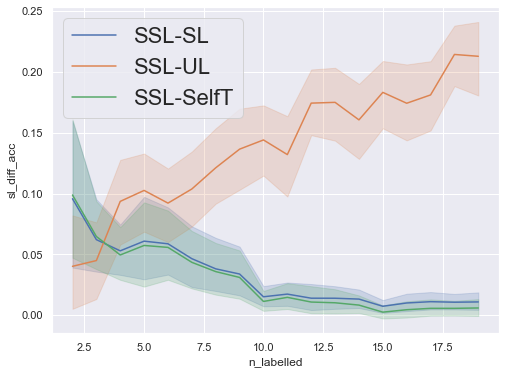

In [83]:
import pandas as pd
import seaborn as sns
# print(df)
val_dict={'n_labelled':n_labelled_arrs,
         'sl_acc':sl_arr,
         'ssl_acc':ssl_arr,
         'ul_acc':ul_arr,
         'sl_diff_acc':sl_diff_arr,
         'ul_diff_acc':ul_diff_arr,
         'st_diff_acc':st_diff_arr,
         }
df=pd.DataFrame.from_dict(val_dict)
import seaborn as sns
sns.set()
fig,ax=plt.subplots(figsize=(8,6))
sns.lineplot(data=df, x='n_labelled', y='sl_diff_acc',ax=ax, label='SSL-SL')
# sns.lineplot(data=df, x='n_labelled', y='ssl_acc',ax=ax, label='SSL')
sns.lineplot(data=df, x='n_labelled', y='ul_diff_acc',ax=ax, label='SSL-UL')
sns.lineplot(data=df, x='n_labelled', y='st_diff_acc',ax=ax, label='SSL-SelfT')
# sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SSL-SL')
ax.legend(fontsize=22)
# plt.yscale('log')

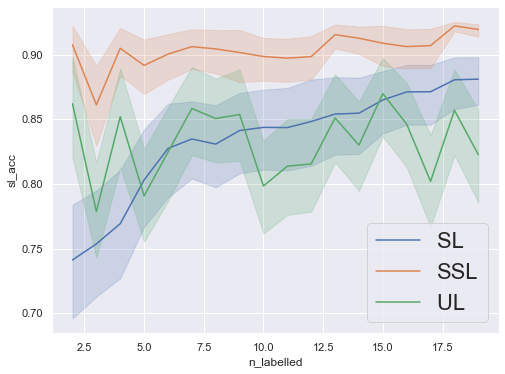

In [329]:
import pandas as pd
import seaborn as sns
# print(df)
val_dict={'n_labelled':n_labelled_arrs,
         'sl_acc':sl_arr,
         'ssl_acc':ssl_arr,
         'ul_acc':ul_arr,
         'sl_diff_acc':sl_diff_arr,
         'ul_diff_acc':ul_diff_arr
         }
df=pd.DataFrame.from_dict(val_dict)
import seaborn as sns
sns.set()
fig,ax=plt.subplots(figsize=(8,6))
sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SL ')
sns.lineplot(data=df, x='n_labelled', y='ssl_acc',ax=ax, label='SSL')
sns.lineplot(data=df, x='n_labelled', y='ul_acc',ax=ax, label='UL ')
# sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SSL-SL')
ax.legend(fontsize=22)

In [396]:
mnist = fetch_openml('mnist_784')
x_all = mnist.data.to_numpy()
y_all = mnist.target.to_numpy(dtype='int')

In [397]:
print(x_all.shape,y_all.shape)

(70000, 784) (70000,)


In [537]:
n_labelled=2
n_unlabelled=2000
num_exps=5
class1_arrs=[[] for _ in range(num_exps)]
class2_arrs=[[] for _ in range(num_exps)]
ssl_arrs=[[] for _ in range(num_exps)]
lambda_arrs=[[] for _ in range(num_exps)]
sl_arrs=[[] for _ in range(num_exps)]
ul_arrs=[[] for _ in range(num_exps)]
margin_arrs=[[] for _ in range(num_exps)]
from sklearn.svm import LinearSVC


for idx in tqdm(range(num_exps)):    
    class1_arr=class1_arrs[idx]
    class2_arr=class2_arrs[idx]
    ssl_arr=ssl_arrs[idx]
    lambda_arr=lambda_arrs[idx]
    sl_arr=sl_arrs[idx]
    ul_arr=ul_arrs[idx]
    margin_arr=margin_arrs[idx]
    for class1 in np.arange(0,10):
        for class2 in range(class1+1, 10):
            while True:
                x_trans,y_subset= get_classes(x_all,y_all, class1=class1, class2=class2)

                x_labelled=x_trans[0:n_labelled]
                x_unlabelled=x_trans[n_labelled:n_labelled+n_unlabelled]
                y=y_subset[0:n_labelled]
                if class1 in y and class2 in y:
                    break


            x_test=x_trans[n_labelled:]
            y_test=y_subset[n_labelled:]
#             svc=LinearSVC(C=10^5)
#             svc.fit(x_test, y_test)
#             margin_=1./np.linalg.norm(svc.coef_)

#     #         if margin_ > 3:
#     #             continue
#             margin_arr.append(margin_)
            class1_arr.append(class1)
            class2_arr.append(class2)





            clf_sl=get_sup_estimator(x_labelled, y)
            clf_em=get_unsup_estimator(x_unlabelled, x_test, y_test)
            sl_score=clf_sl.score(x_test, y_test)
            ul_score=clf_em.score(x_test, y_test)
            best_lambda, ssl_score = get_best_lambda(clf_sl, clf_em, x_test, y_test)
            ssl_arr.append(ssl_score)
            lambda_arr.append(best_lambda)
            sl_arr.append(sl_score)
            ul_arr.append(ul_score)


class1_arrs=np.mean(class1_arrs, axis=0)
class2_arrs=np.mean(class2_arrs, axis=0)
ssl_arrs=np.mean(ssl_arrs, axis=0)
lambda_arrs=np.mean(lambda_arrs, axis=0)
sl_arrs=np.mean(sl_arrs, axis=0)
ul_arrs=np.mean(ul_arrs, axis=0)
margin_arrs=np.mean(margin_arrs, axis=0)

100%|█████████████████████████████████████████████████████| 5/5 [03:26<00:00, 41.35s/it]


Text(0, 0.5, '$\\lambda$')

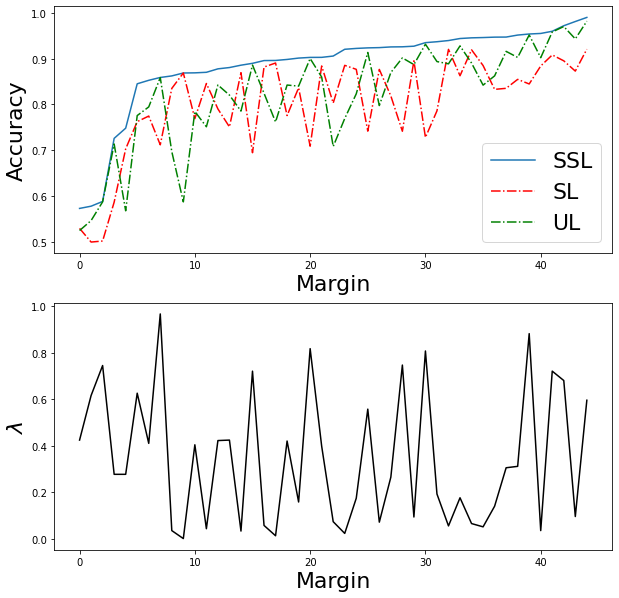

In [544]:
fig,ax=plt.subplots(2,1,figsize=(10,10)) 
def sort_with(arr_, idx_):
    return [arr_[i] for i in idx_]
sort_idx=np.argsort(ssl_arrs)
ax[0].plot(sort_with(ssl_arrs, sort_idx), 
           label='SSL')
ax[0].plot(sort_with(sl_arrs, sort_idx), 
           label='SL', color='r', linestyle='-.',)
ax[0].plot(sort_with(ul_arrs, sort_idx), 
           label='UL', linestyle='-.', color='g')
# ax[0].set_ylim(0.8,1)
ax[0].legend(fontsize=22)
ax[0].set_xlabel('Margin', fontsize=22)
ax[0].set_ylabel('Accuracy', fontsize=22)
ax[1].plot(sort_with(lambda_arrs, sort_idx),
           linestyle='-', color='k')
ax[1].set_xlabel('Margin', fontsize=22)
ax[1].set_ylabel('$\lambda$', fontsize=22)